In [65]:
from algorithm import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [2]:
def get_nu_star(xi, params):

    def objective(nu):

        if xi(nu, **params)>0:
            return -(np.log(xi(nu, **params)) - 0.5*np.dot(nu.T, nu))
        else:
            return 1e80
        
    nu0 = np.zeros(params["d"])

    result = minimize(objective, nu0, method='SLSQP')

    if result.success:
        return result.x/np.linalg.norm(result.x)
    else:
        raise ValueError("L'optimisation n'a pas réussi à converger.")

# Asian Option

In [49]:
def asian_function(y, S0, v, mu, maturity, strike, rate, d):

    k = np.arange(1, d + 1)
    y_cum = np.cumsum(y)
    payoff = np.exp(-rate*maturity)*max(S0*np.sum(np.exp(mu*(k*maturity)/d + v*np.sqrt(maturity/d)*y_cum))/d - strike, 0)

    return payoff

In [50]:
d = 16
T = 1
r = 0.05
S0 = 50
K = 45
v = 0.1

params_asian = {
    "d": d,
    "S0": S0,
    "v": v,
    "mu": r-0.5*v**2,
    "maturity": T,
    "strike": K,
    "rate": r
}

In [51]:
I = 100
M = 20000
mean = np.zeros(d)
cov = np.eye(d)

drift_vector_asian = get_nu_star(asian_function, params_asian)


phi_asian = lambda y: np.exp(- drift_vector_asian.T @ y - 0.5*drift_vector_asian.T @ drift_vector_asian)*asian_function(y + drift_vector_asian, params_asian['S0'], params_asian['v'], params_asian['mu'], params_asian['maturity'], params_asian['strike'], params_asian['rate'], params_asian['d'])

In [57]:
algo_asian = Algorithm(M,
                 I,
                 d,
                 phi_asian,
                 mean,
                 cov)

N = 200
V_asian, mus_asian = algo_asian.compute_algorithm_iteration(N)

In [58]:
V_asian

array([1.61140363, 1.6195951 , 0.5006181 , 1.96118332, 1.0673433 ,
       2.39631636, 2.19627709, 2.8048055 , 1.14651022, 3.18027016,
       1.28581175, 2.8868816 , 1.65309579, 1.61604286, 0.75470573,
       1.58066556, 0.67263363, 1.47119994, 0.5391994 , 1.98485437,
       0.83070469, 2.09005096, 1.53504265, 1.63940815, 0.79904751,
       1.37606897, 0.52318573, 1.12931236, 0.62121853, 1.47469093,
       0.70430522, 1.28007622, 0.5933763 , 1.18040562, 0.67990603,
       1.26613371, 0.60186923, 1.7181892 , 0.67237809, 1.25372108,
       0.47106201, 1.33099128, 0.72752244, 1.10135107, 0.83303017,
       1.13515616, 0.65645877, 1.19759817, 0.6432708 , 1.15583112,
       0.65798692, 1.03638729, 0.59563203, 1.01368912, 1.19868023,
       1.11171512, 0.94927876, 0.88340266, 1.00787483, 1.00402294,
       0.86107301, 0.87850706, 1.13276815, 0.62124378, 1.01637066,
       0.89838003, 1.00075483, 1.00668954, 0.86678985, 0.96780586,
       0.8960797 , 0.85580625, 0.99624336, 0.82720188, 0.97835

In [66]:
df = pd.DataFrame(V_asian)

In [79]:
df.ewm(alpha=0.3).mean()

,0
0,1.611404
1,1.616222
2,1.106814
3,1.444109
4,1.308245
...,...
196,0.927305
197,0.923621
198,0.908334
199,0.904935


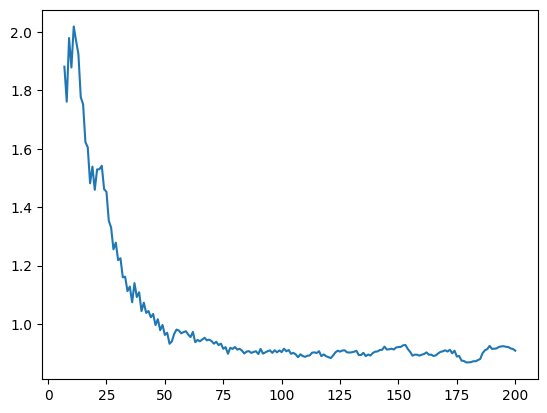

In [87]:
plt.plot(df.ewm(alpha=0.1).mean()[7:])

# Barrier Option

In [88]:
def knock_out_function(y, S0, v, mu, maturity, strike, rate, barrier, d):

    d = len(y)
    k = np.arange(1, d + 1)
    y_cum = np.cumsum(y)

    s = S0*np.exp(mu*maturity + v*np.sqrt(maturity/d)*y_cum[-1])
    payoff = np.exp(-rate*maturity)*max(S0*np.sum(np.exp(mu*(k*maturity)/d + v*np.sqrt(maturity/d)*y_cum))/d - strike, 0)*(1 if s <= barrier else 0)

    return payoff

In [89]:
d = 16
T = 1
r = 0.05
S0 = 50
K = 50
B = 60
v = 0.1

params_barrier = {
    "d": d,
    "S0": S0,
    "v": v,
    "mu": r-0.5*v**2,
    "maturity": T,
    "strike": K,
    "rate": r, 
    "barrier": B
}

In [90]:
I = 100
M = 20000
mean = np.zeros(d)
cov = np.eye(d)

drift_vector_barrier = get_nu_star(knock_out_function, params_barrier)


phi_barrier = lambda y: np.exp(- drift_vector_barrier.T @ y - 0.5*drift_vector_barrier.T @ drift_vector_barrier)*knock_out_function(y + drift_vector_barrier, params_barrier['S0'], params_barrier['v'], params_barrier['mu'], params_barrier['maturity'], params_barrier['strike'], params_barrier['rate'], params_barrier['barrier'], params_barrier['d'])

In [92]:
algo_barrier = Algorithm(M,
                         I,
                         d,
                         phi_barrier,
                         mean,
                         cov)

N = 200
V_barrier, mus_barrier = algo_barrier.compute_algorithm_iteration(N)

# Basket Option

In [ ]:
def basket_options_function(y, S0, v, mu, sq_correl, maturity, strike, alpha, rate, d):

    y_tilde = np.dot(sq_correl, y)
    payoff = np.exp(-rate*maturity)*max(np.sum(alpha*S0*np.exp(mu*T + v*np.sqrt(maturity)*y_tilde)) - strike, 0)

    return payoff

In [27]:
d = 40
T = 1
r = 0.05
S0 = np.random.uniform(20, 80, d)
K = 45
alpha = np.ones(d)/d

c = 0.1
sigma = c*np.ones((d, d)) + (1-c)*np.eye(d)
v = np.linspace(0.1, 0.4, d)

params_basket = {
    "d": d,
    "S0": S0,
    "v": v,
    "mu": r-0.5*v**2,
    "sq_correl": np.linalg.cholesky(sigma),
    "maturity": T,
    "strike": K,
    "alpha": alpha,
    "rate": r
}

In [ ]:
I = 100
M = 20000
mean = np.zeros(d)
cov = np.eye(d)

drift_vector_basket = get_nu_star(knock_out_function, params_barrier)


phi_basket = lambda y: np.exp(- drift_vector_basket.T @ y - 0.5*drift_vector_basket.T @ drift_vector_basket)*asian_function(y + drift_vector_barrier, params_barrier['S0'], params_barrier['v'], params_barrier['mu'], params_barrier['maturity'], params_barrier['strike'], params_barrier['rate'], params_barrier['d'])

## Test fonction